$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$



# Convolutional Neural Networks

<br/>
<br/><br/><br/>

### ITCS4156

### Minwoo "Jake" Lee

# Goal

The goal of this activity is to implement s convolutional neural network (CNN) to classify Fashion-MNIST image dataset in TensorFlow Keras. We will use the convolutional layers to learn filters that will, in turn, extract features from raw images. Combining these extracted features with our typical dense layers, we will then classify our raw image. Follow the TODO titles and comments to finish the activity!

# Agenda

1.  Fashion-MNIST
    - Downloading
    - Visualization
    - Data Preprocessing
2. CNN
    - Building Model
    - Training Model
    - Testing Model

In [1]:
# preparation
import tensorflow as tf
from tensorflow import keras 
# Common imports
import numpy as np
import pandas as pd
from copy import deepcopy as copy

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #TF2: to fix Jupyter down

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output

# Fashion-MNIST

Here we'll be using the fashion version of the MNIST dataset. This is exactly what it sounds like. The Fashion-MNIST dataset simply uses pictures of clothing, shoes, and bags instead of handwritten digits.

> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

If you want to know more check out the Fashion-MNIST official [GitHub repo](https://github.com/zalandoresearch/fashion-mnist)

## Downloading

Luckily, TensorFlow Keras has already added Fashion-MNIST dataset to their library. So, we'll load it using `keras.datasets` in the following code. 

For future reference, here are the labels (targets) and names for each of the dataset's classes - we'll be using these shortly.

> 0 T-shirt/top<br/>
> 1 Trouser<br/>
> 2 Pullover<br/>
> 3 Dress<br/>
> 4 Coat<br/>
> 5 Sandal<br/>
> 6 Shirt<br/>
> 7 Sneaker<br/>
> 8 Bag<br/>
> 9 Ankle boot

Here, we are simply constructing the aforementioned class names. Each index of a class name corresponds to its label. For instance, 'T-shirt/top' has a label of 0, thus it's in the 0 index position of our list.

In [2]:
n_label = [ 'T-shirt/top', 'Trouser', 'Pullover', 
            'Dress', 'Coat', 'Sandal', 'Shirt', 
            'Sneaker', 'Bag', 'Ankle boot']

Here we load the Fashion-MNIST data using `keras.datasets.fashion_mnist.load_data()`. This function returns the train and test image data, including labels. 

The last step we must do here is normalize our data by dividing by 255. We divide by 255 because each individual pixel value is between 0 and 255. Thus, dividing by 255 then scales each individual pixel value to be between 0 and 1 (essentially normalization). 

Also, note that we are casting our data as type `np.float32`. The default type is typically `np.float64` which can be extremely expensive to store and preform computations on. Thus, we typically scale the float type down to 32 bits when we can for images.

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [5]:
print("Training data shape: {}".format(X_train.shape))
print("Training labels shape: {}".format(y_train.shape))

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)


Next, we'll store the number of samples for both the training and test data.

In [6]:
Ntrain, Ntest = X_train.shape[0], X_test.shape[0]

## Visualization

Below we'll define some plotting functions that will allow us to visualize our images and their corresponding labels.

In [7]:
def plot_image(image, name):
    """
        Plot and image and its corresponding name.
        
        image (numpy.ndarray): Image to be plotted.
        
        name (str): Name of the image that will act as the title.
    """
    plt.imshow(image, cmap="binary")
    plt.title(name)
    plt.axis("off")

In [8]:
def plot_nImages(X, y, n=100):
    """
        Plots image data and their labels.
        
        X (numpy.ndarray): Image training data.
        
        y (numpy.ndarray): Labels for images formatted as 1-D vector.
    """
    plt.figure(figsize=(12,12))
    nr = int(np.ceil(np.sqrt(n)))
    
    # Remove channel dimension for plotting
    if len(X.shape) > 3:
        X = X.squeeze()
        
    for i in range(n):
        plt.subplot(nr, nr, 1 + i)
        plot_image(X[i], n_label[y[i]])
    plt.tight_layout()


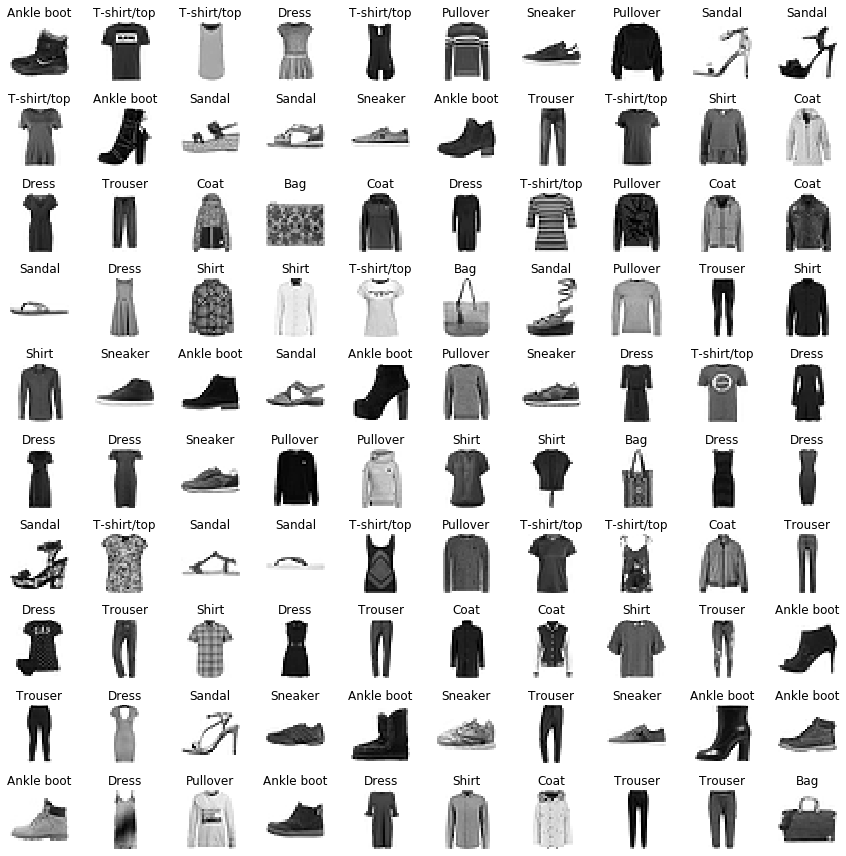

In [9]:
plot_nImages(X_train, y_train, 100)

Now we need to check out data distribution to make sure all our labels contain equal amounts of data.

Below we get the counts for each of our labels by casting our `y_train`  array as a Pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) (similar to a DataFrame) and using the `.value_counts()` method. As well see, all the classes will be even!

In [10]:
pd.Series(y_train).value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

## Data Preprocessing

What kind of preprocessing do you think we need for CNN? 

Well, we are playing with CNN that directly uses the raw image input! This means there is very little to no preprocessing. This is the beauty of an [end-to-end model](https://www.quora.com/What-does-end-to-end-mean-in-deep-learning-methods?share=1)!

Technically, the only preprocessing here was changing the data type to `np.float32` and dividing our image data by 255. But, we'll cheat and say the answer is essentially none. :) 

# CNN

Below is the CNN we want to create. It contains 7 layers, including the input layer. 

Let's see if you can read this CNN diagram. Here the CNN layer information is placed between the stacks of blue squares. You can think of the stacks of blue squares as representing the learned filters, which act as the input/output of a each layer. For instance, layer 2 is placed between the image of the shoe and the stack of 32 blue squares (filters). This is because the shoe acts as the input into the layer 2 and the stack of blue squares (filters) act as the outputs. However, there is an exception when we get to the dense layers (layer 6 and 7). Here we revert back to our typical format of placing the layer information above each dense layer (same goes for the input layer).

Next,you can find the dimensions of the input/output of each layer at the bottom of the image. Let's look at layer 2 again as an example. Here we can see the original dimension of the input layer was (28x28x1). Now, after passing through layer 2 we can see the dimensions have changed to (28x28x32). This is because layer 2 applies 32 filters to our input image with same padding. Remember same padding allows the width and height dimensions to maintain their (28x28) shape!

<img src="https://i.imgur.com/nb4PCs3.png">

### References

If you're still a little fuzzy on CNNs check out this great post from the Stanford CS231 class. It even has a great interactive visualization of how CNN weights correspond to neural network neurons!

- [CS231 Class Notes](http://cs231n.github.io/convolutional-networks/)


## Building Model

Building CNN models can be very expensive memory and computation wise. As we'll see our simple model will have 800k trainable parameters!

### TODO:

1. Build our CNN model described in the above diagram. Here we need to build a `keras.Sequential` model with a ` keras.layers.Input` layer, 2 `tf.keras.layers.Conv2D` layers, 1 ` tf.keras.layers.MaxPooling2D`, 1 `tf.keras.layers.Flatten` layer and 2 `tf.keras.layers.Dense` layers.
    1. Hint: The parameters for each layer are given in the diagram above!

In [11]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv2_fmaps = 64

n_fc1 = 64
n_outputs = 10

In [12]:
from functools import partial

# Partially declares a class - can later be fully initialized!
DefaultConv2D = partial(tf.keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")


# TODO (1)
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    DefaultConv2D(filters=conv1_fmaps),
    DefaultConv2D(filters=conv2_fmaps),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=n_fc1, activation='relu'),
    tf.keras.layers.Dense(units=n_outputs, activation='softmax'),
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 822,346
Trainable params: 822,346
Non-trainable params: 0
__________________________________________________

In [13]:
cnn.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Training Model

### TODO:

Try to run the following training code. You should be observing a TensorFlow error. Trying take a moment to decipher the below error. What do you think caused it?

In [14]:
history = cnn.fit(X_train, y_train, epochs=5, validation_split=0.2)

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (60000, 28, 28)

If you guessed this error is due to a missing dimension you are correct! More specifically, we are missing our channel dimension! The channel dimension is used to store our learned filters as our data passes through the CNN. Typically, we have the following 4 dimensions: (batch, width, height, filter).

Let's check our data shape to confirm our channel dimension is indeed missing!

In [15]:
X_train.shape

(60000, 28, 28)

In [16]:
X_test.shape

(10000, 28, 28)

As we can see from the above shapes we are missing the filter dimension. What we really want is a shape of (?, 28, 28, 1), where the $?$ can be any number (further description on the $?$ symbol in TensoFlow can be found in this [stack overflow discussion](https://stackoverflow.com/questions/40951602/what-does-the-question-mark-in-tensorflow-shape-mean)). So, let's add one!

### TODO: 

1. Try fixing the error by adding the filter dimension to the end of our `X_train` and `X_test`.
    1. Hint: If you forgot how to add new dimensions to NumPy arrays check out the this [stack overflow discussion](https://stackoverflow.com/questions/17394882/how-can-i-add-new-dimensions-to-a-numpy-array)

In [17]:
# TODO (1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

#### But wait........

It will take a long time if you use the entire 60k dataset for training. To finish all the computation in the lab, let's only use a small portion of the dataset.

Below we define a function that allows us to take a small portion of the dataset and an even amount of samples for each class.

In [18]:
def use_smaller_train(X, y, ratio=0.1):
    """
        X (numpy.ndarray): Data to be subsampled
        
        y (numpy.ndarray): Labels corresponding to the data
        
        ratio (float): Percent of data to use from each class 
        
        Return:
            Return a portion of the pass data X and their corresponding labels y
    """
    N = X.shape[0]
    labels = np.unique(y)
    indx = []
    for lbl in labels:
        l_idx = np.where(y_train==lbl)[0]
        Nslice = int(len(l_idx) * ratio)
        indx.extend(l_idx[:Nslice])
    return X[indx], y[indx]

In [19]:
mini_Xtrain, mini_ytrain = use_smaller_train(X_train, y_train)

There we go! We now have a small portion of our dataset. Hopefully, our training time will be greatly reduced now!

In [20]:
mini_Xtrain.shape, mini_ytrain.shape

((6000, 28, 28, 1), (6000,))

Now let's run our cnn model. 

If you are running out of memory try reducing the `batch_size` parameter to a smaller value, say 512, 256, or 128. Reducing the batch size will increase the time it takes the model to learn (due to less samples being used in backprop at any given time), but it does save on memory space.

If your model is taking too long to train then try reducing the  `epochs` parameter to a smaller value. Doing so could decrease the performance of the model as it will have passed over the data less. Remember, each epoch means we have done a full pass over the data (i.e. one pass typically means we have updated the weights for all our data once).

In [21]:
history = cnn.fit(X_train, y_train, batch_size=1000, epochs=5, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 4s 87us/sample - loss: 0.8798 - accuracy: 0.6932 - val_loss: 0.5600 - val_accuracy: 0.7934
Epoch 2/5
48000/48000 [==============================] - 3s 59us/sample - loss: 0.4531 - accuracy: 0.8378 - val_loss: 0.3953 - val_accuracy: 0.8593
Epoch 3/5
48000/48000 [==============================] - 3s 61us/sample - loss: 0.3772 - accuracy: 0.8652 - val_loss: 0.3496 - val_accuracy: 0.8757
Epoch 4/5
48000/48000 [==============================] - 3s 61us/sample - loss: 0.3342 - accuracy: 0.8819 - val_loss: 0.3243 - val_accuracy: 0.8831
Epoch 5/5
48000/48000 [==============================] - 3s 61us/sample - loss: 0.3139 - accuracy: 0.8873 - val_loss: 0.3028 - val_accuracy: 0.8928


Text(0, 0.5, 'loss')

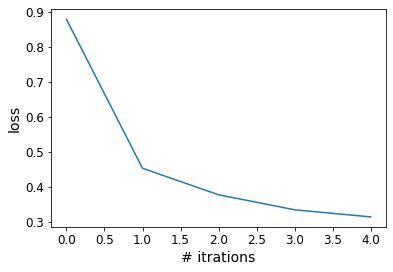

In [22]:
plt.plot(history.history['loss'])
plt.xlabel("# itrations")
plt.ylabel("loss")

# Evaluation and Visualization


Now, let's see how well the trained model works on our unseen test data.

### TODO:

1. Use `.evaluate()` method to compute the loss and accuracy of the test data, `X_test` and `y_test`. Store the output into `score`.

    
2.  Compute the probabilities for our `X_test` data by using the `.predict()` method on our `cnn` model. Store the output into `Ytest_probs`.


3. Compute the predictions by taking the `np.argmax()` of our probability array `Ytest_probs`. Store the output into `Ytest_preds`.
    1. **Hint: Be sure to take the argmax over the correct axis, i.e. the row axis.**
    
    
4. Plot 100 of our test images `X_test` and their predicted labels `Ytest_preds` using the `plot_nImages()` function we defined and used previously.
    1. **Hint: Simply passing the parameter `n=100` will print the first 100 images and thier labels for you. There is no need to slice any arrays!**

In [23]:
# TODO (1)
score = cnn.evaluate(X_test, y_test)
score

10000/10000 [==============================] - 1s 62us/sample - loss: 0.3196 - accuracy: 0.8877


[0.31961377396583557, 0.8877]

In [24]:
# TODO (2)
Ytest_probs = cnn.predict(X_test)
# TODO (3)
Ytest_preds = np.argmax(Ytest_probs, axis=1)

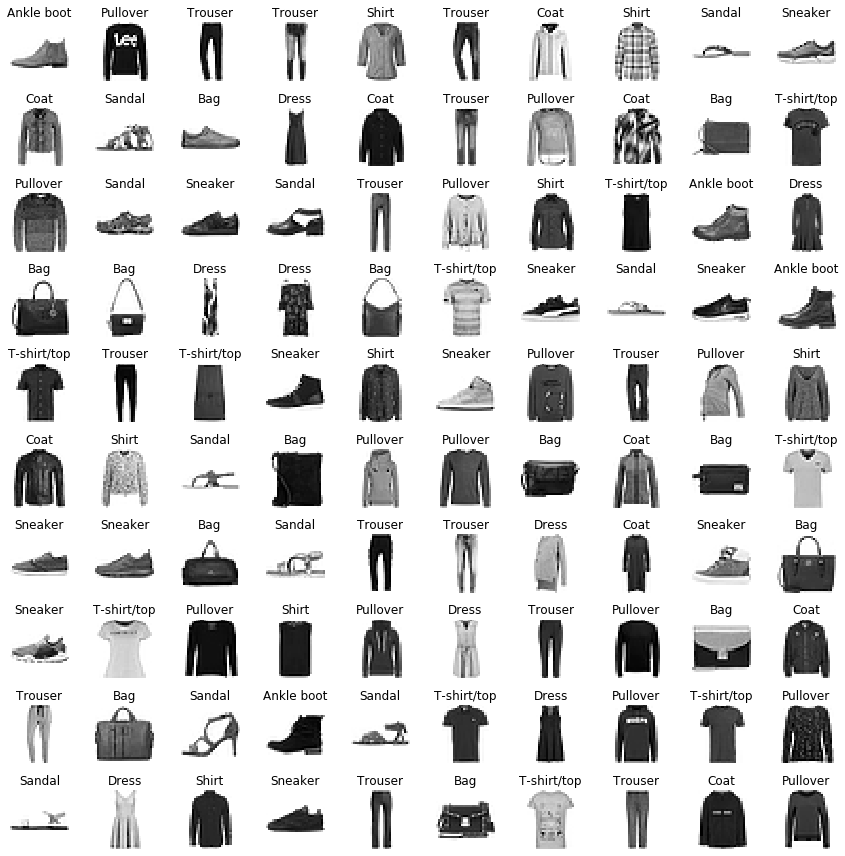

In [25]:
# TODO (4)
plot_nImages(X_test, Ytest_preds, 100)

Looking at the pictures above, can you find the images that have the wrong classification label. Sounds pretty tedious, right? If you did look, did you see any wrong predictions?   

Since manually verifying which predictions are correct or incorrect is extremely tedious let's write code that'll do it for us!

### TODO:

1. Using `np.where()` write code that will find the mislabeled images for the first **100 test images**.
    1. Hint: Find where the first 100 labels for `Ytest_preds` and `y_test` are not equal! This will give the corresponding indices for the images that were misclassified.
    2. Hint: See this [stack overflow discussion](https://stackoverflow.com/questions/25551977/retrieve-misclassified-documents-using-scikitlearn) for a similar example of how to find mislabeled samples using `np.where()`.

In [28]:
# Check if all preds equal thier corresponding ground truth label
mislabeled = np.all(Ytest_preds[:100] == y_test[:100])
mislabeled

False

In [30]:
#TODO (1)
mislabeled_indices = np.where(Ytest_preds[:100] != y_test[:100])
mislabeled_indices

(array([12, 23, 25, 40, 42, 49, 51, 66, 67, 68, 89]),)

### BONUS TODO (1):

Now, try to use the entire dataset with better computing resources (either MAMBA GPU cluster or cloud computing services). How much time were you able to save? What is the accuracy when you use more data for training?